# **Multi-agent Systems**

An `agent` is a system that uses an **LLM** to decide the control flow of an application. As you develop these systems, they might grow more complex over time, making them harder to manage and scale. For example, you might run into the following problems:

- agent has too many tools at its disposal and makes poor decisions about which tool to call next
- context grows too complex for a single agent to keep track of
- there is a need for multiple specialization areas in the system (e.g. planner, researcher, math expert, etc.)

To tackle these, you might consider breaking your application into multiple smaller, independent agents and composing them into a **multi-agent system**. 

These independent agents can be as **simple as a prompt and an LLM call**, or as complex as a `ReAct` agent (and more!).

**The primary benefits of using multi-agent systems are:**

- **Modularity:** Separate agents make it easier to develop, test, and maintain agentic systems.
- **Specialization:** You can create expert agents focused on specific domains, which helps with the overall system performance.
- **Control:** You can explicitly control how agents communicate (as opposed to relying on function calling).


## **Multi-agent architectures**

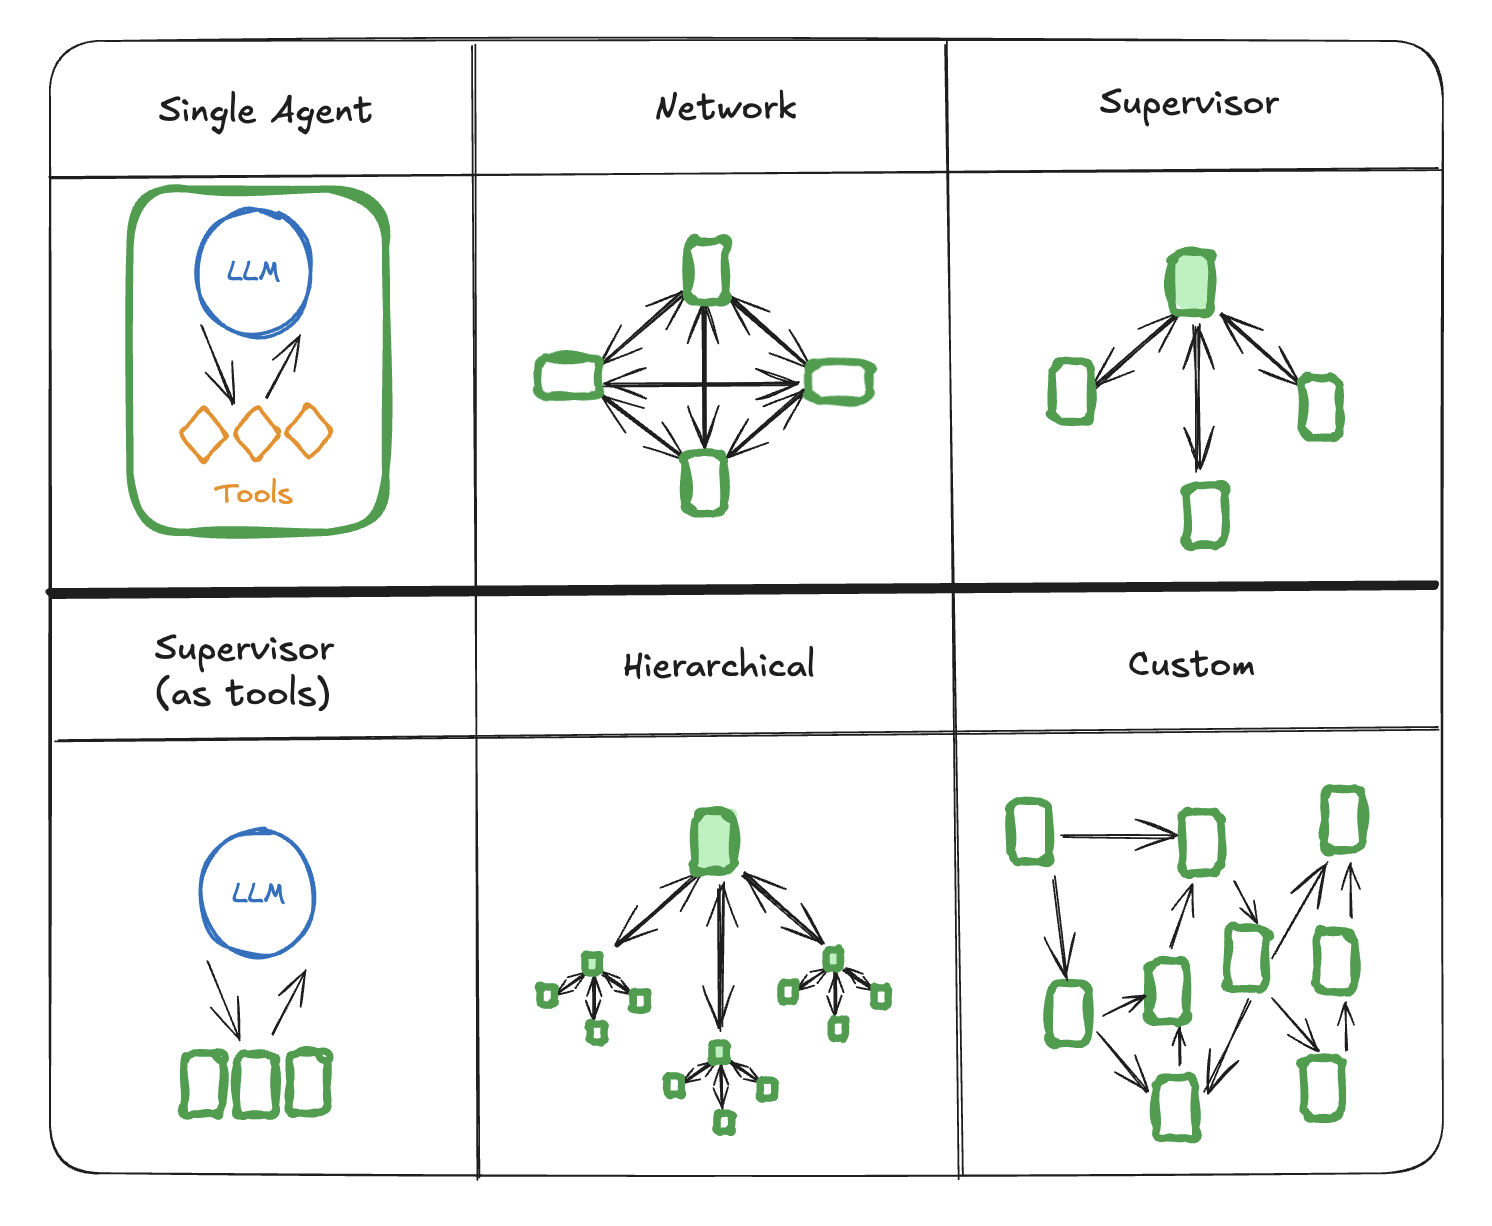

There are several ways to connect agents in a multi-agent system:

- **Network:** each agent can communicate with `every other agent`. Any agent can decide which other agent to call next.

- **Supervisor:** each agent communicates with a single `supervisor` agent. Supervisor agent makes decisions on which agent should be called next.

- **Supervisor (tool-calling):** this is a special case of supervisor architecture. Individual agents can be represented as tools. In this case, a supervisor agent uses a tool-calling LLM to decide which of the agent tools to call, as well as the arguments to pass to those agents.

- **Hierarchical:** you can define a multi-agent system with a `supervisor of supervisors`. This is a generalization of the supervisor architecture and allows for more complex control flows.

- **Custom multi-agent workflow:** each agent communicates with only a subset of agents. Parts of the flow are deterministic, and only some agents can decide which other agents to call next.

### **Handoffs**

In multi-agent architectures, agents can be represented as graph nodes. Each agent node executes its step(s) and decides whether to finish execution or route to another agent, including potentially routing to itself (e.g., running in a loop). A common pattern in multi-agent interactions is handoffs, where one agent hands off control to another. Handoffs allow you to specify:

- **destination:** target agent to navigate to (e.g., name of the node to go to)
- **payload:** information to pass to that agent (e.g., state update)

To implement handoffs in LangGraph, agent nodes can return `Command` object that allows you to combine both control flow and state updates:

In [ ]:
def agent(state) -> Command[Literal["agent", "another_agent"]]:

    # the condition for routing/halting can be anything, e.g. LLM tool call / structured output, etc.
    goto = get_next_agent(...)  # 'agent' / 'another_agent'
    
    return Command(
        # Specify which agent to call next
        goto=goto,
        # Update the graph state
        update={"my_state_key": "my_state_value"}
    )

# **Multi-agent network**

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a `multi-agent network architecture`.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

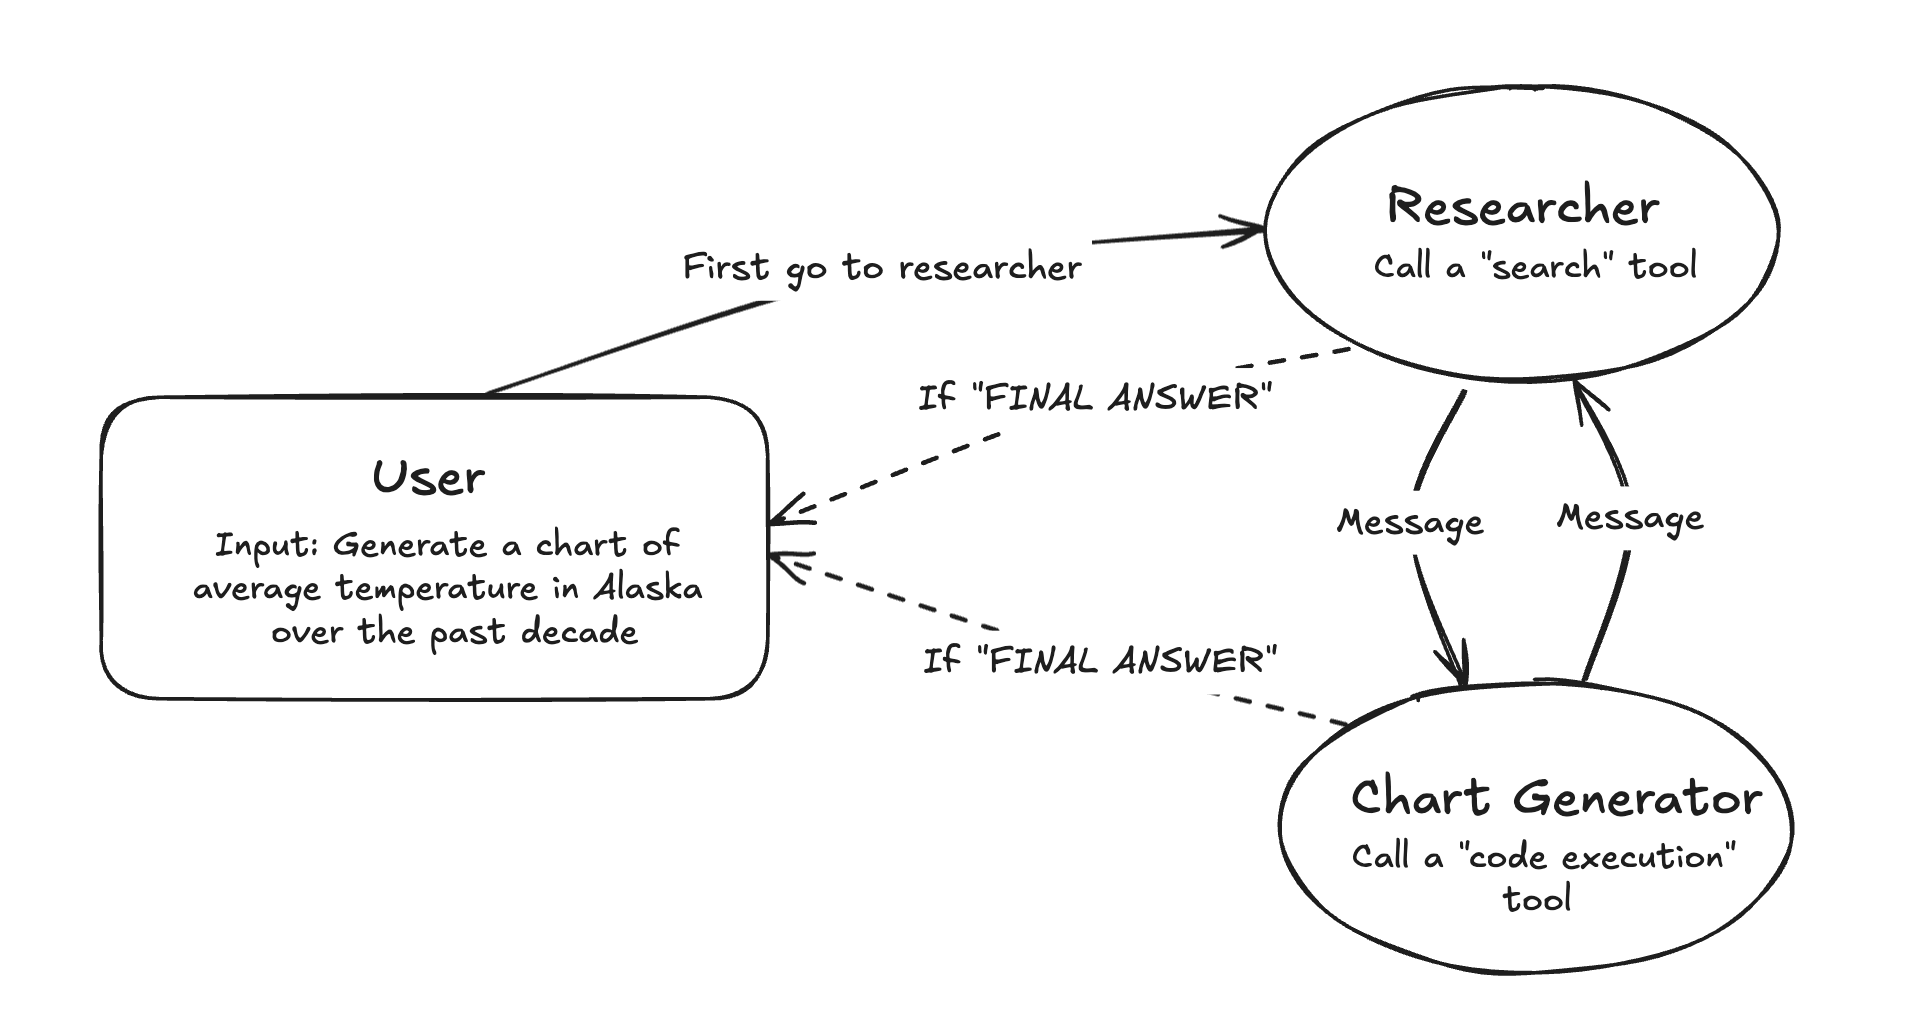

**Quick Note:** This and other multi-agent notebooks in `LangGraph` docs are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## **Setup**

**Load your API keys**

In [42]:
from dotenv import load_dotenv

load_dotenv()

True

**Install 2 new libraries if you don't already have them**

In [ ]:
# ! pip install langchain_experimental matplotlib

## **LLM**

In [15]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

In [28]:
# llm = ChatGroq(model="llama-3.3-70b-versatile")

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

## **Define tools**

We will also define some tools that our agents will use in the future

In [29]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

In [30]:
## Search Tool
tavily_tool = TavilySearchResults(max_results=5)


## Code Runner tool

# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()


@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
        
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    
    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")

## **Create graph**


Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### **Define Agent Nodes**

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [31]:
def make_system_prompt(suffix: str) -> str:
    
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [32]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [33]:
## Define how to get to the next node

def get_next_node(last_message: BaseMessage, goto: str):
    
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

#### **Research agent and node**

In [37]:
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(state: MessagesState,) -> Command[Literal["chart_generator", "__end__"]]:

    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


#### **Chart generator agent and node**

In [ ]:
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED

chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", "__end__"]]:

    result = chart_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "researcher")

    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

## **Define the Graph**

We can now put it all together and define the graph!

In [39]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

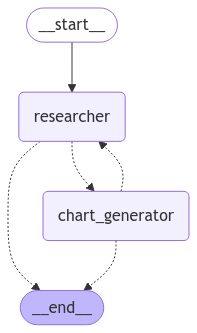

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### **Test**

In [41]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 1 year, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 1 year, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='7d57bc1e-647a-4051-b2f1-bb92db04e3fd'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JUkX4TVSJAkUCmvUvO5crPrQ', 'function': {'arguments': '{"query":"UK GDP over the past 1 year"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 212, 'total_tokens': 237, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ca90ff95-5724-4031-b25c-33438bc3a12c-0', tool_calls=[{'name': 'tavily_searc